<a href="https://colab.research.google.com/github/vanessacannizzaropolimi/US_Simulation/blob/main/examples/us_bmode_phased_array/kwave_liver_adjusted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%%capture
!pip install git+https://github.com/waltsims/k-wave-python

In [11]:
from copy import deepcopy

import os
import numpy as np
import scipy.io
from scipy.ndimage import zoom
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
import nibabel as nib

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ktransducer import NotATransducer, kWaveTransducerSimple
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.reconstruction.beamform import envelope_detection, scan_conversion
from kwave.reconstruction.tools import log_compression
from kwave.utils.conversion import db2neper
from kwave.utils.dotdictionary import dotdict
from kwave.utils.filters import gaussian_filter
from kwave.utils.mapgen import make_ball
from kwave.utils.signals import get_win, tone_burst
from kwave.utils.conversion import hounsfield2density, hounsfield2soundspeed

In [12]:
# simulation settings
DATA_CAST = 'single'
RUN_SIMULATION = True

In [13]:
"""Grid and PML"""
pml_size_points = Vector([15, 10, 10])  # [grid points]
grid_size_points = Vector([256, 256, 128]) - 2 * pml_size_points  # [grid points]
grid_size_meters = 50e-3  # [m]
grid_spacing_meters = grid_size_meters / Vector([grid_size_points.x, grid_size_points.x, grid_size_points.x])
grid_center = grid_size_points / 2.0

"""Medium"""
c0 = 1540
rho0 = 1000

medium = kWaveMedium(
    sound_speed=None,  # will be set later
    # sound_speed_ref=None,
    alpha_coeff=0.75,
    alpha_power=1.5,
    BonA=6
)

In [14]:
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)
t_end = (grid_size_points.x * grid_spacing_meters.x) * 2.2 / c0  # [s]
kgrid.makeTime(c0, t_end=t_end)

(Vector([[0.00000000e+00, 4.30984944e-08, 8.61969889e-08, ...,
          7.13280083e-05, 7.13711068e-05, 7.14142053e-05]]),
 Vector(4.30984944e-08))

In [15]:
source_strength = 1e6  # [Pa]
tone_burst_freq = 1e6  # [Hz]
tone_burst_cycles = 4

input_signal = tone_burst(1 / kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength / (c0 * rho0)) * input_signal

In [16]:
transducer = dotdict()
transducer.number_elements = 64  # total number of transducer elements
transducer.element_width = 1  # width of each element [grid points/voxels]
transducer.element_length = 40  # length of each element [grid points/voxels]
transducer.element_spacing = 0  # spacing (kerf  width) between the elements [grid points/voxels]
transducer.radius = float('inf')  # radius of curvature of the transducer [m]

# calculate the width of the transducer in grid points
transducer_width = transducer.number_elements * transducer.element_width + (
        transducer.number_elements - 1) * transducer.element_spacing

# use this to position the transducer in the middle of the computational grid
transducer.position = np.round([
    1,
    grid_size_points.y / 2 - transducer_width / 2,
    grid_size_points.z / 2 - transducer.element_length / 2
])
transducer = kWaveTransducerSimple(kgrid, **transducer)

In [17]:
not_transducer = dotdict()
not_transducer.sound_speed = c0  # sound speed [m/s]
not_transducer.focus_distance = 30e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 30e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle = 0  # steering angle [degrees]
not_transducer.steering_angle_max = 32  # steering angle [degrees]
not_transducer.transmit_apodization = 'Hanning'
not_transducer.receive_apodization = 'Rectangular'
not_transducer.active_elements = np.ones((transducer.number_elements, 1))
not_transducer.input_signal = input_signal

not_transducer = NotATransducer(transducer, kgrid, **not_transducer)

DEBUG: BACKGROUND
Minimum SOUND SPEED in BACKGROUND:  1476.1788325202263
Maximum SOUND SPEED in BACKGROUND:  1604.4563360479822
Minimum DENSITY in BACKGROUND:  958.5576834546924
Maximum DENSITY in BACKGROUND:  1041.8547636675207
DEBUG: SPHERIC PHANTOM
Minimum SOUND SPEED in SPHERIC PHANTOM:  1400.0
Maximum SOUND SPEED in SPHERIC PHANTOM:  1600.0
Minimum DENSITY in SPHERIC PHANTOM:  933.3333333333334
Maximum DENSITY in SPHERIC PHANTOM:  1066.6666666666667
Minimum SOUND SPEED in SPHERIC PHANTOM + BACKGROUND:  1400.0
Maximum SOUND SPEED in SPHERIC PHANTOM + BACKGROUND:  1601.0133152827805
Minimum DENSITY in SPHERIC PHANTOM + BACKGROUND:  933.3333333333334
Maximum DENSITY in SPHERIC PHANTOM + BACKGROUND:  1066.6666666666667
DEBUG: CT VOLUME RESAMPLING
CT resolution in mm/voxel:  [0.703125 0.703125 5.      ]
CT dimensons in voxel:  [43 44  4]
CT dimensons in mm:  [30.234375 30.9375   20.      ]
Grid resolution in mm/voxel:  [0.22123894 0.22123894 0.22123894]
Grid dimensons in voxel:  [226 2

<ipython-input-18-0e67beb323fb>:126: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(hu_vals, d_vals, 1)


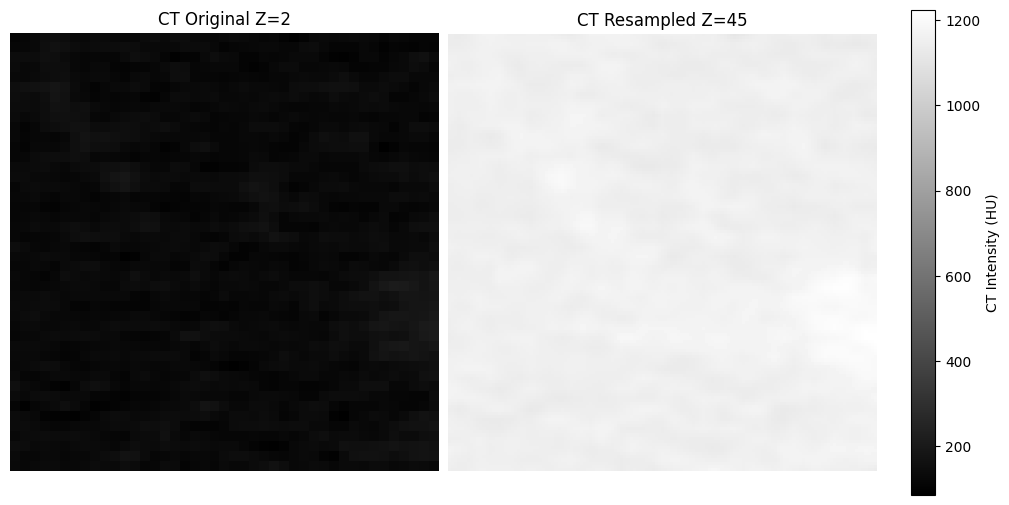

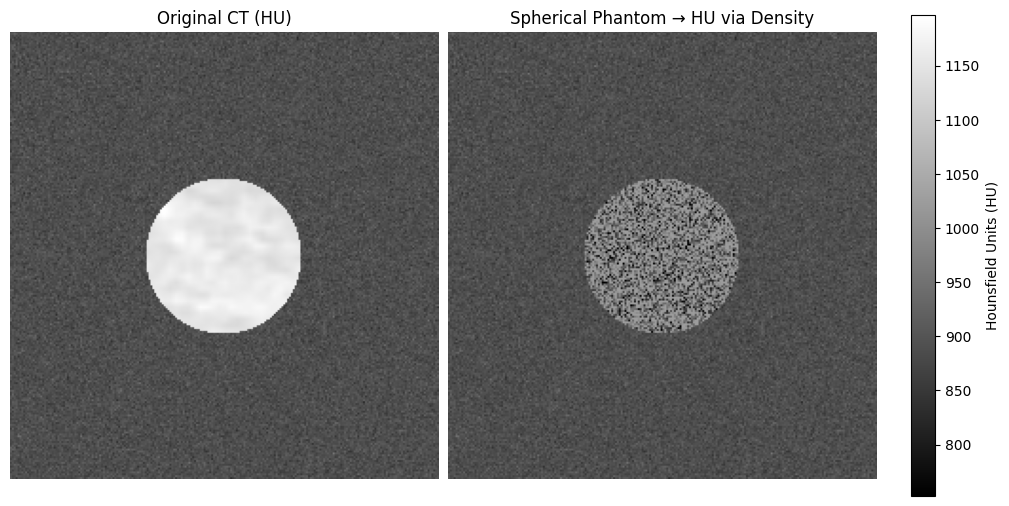

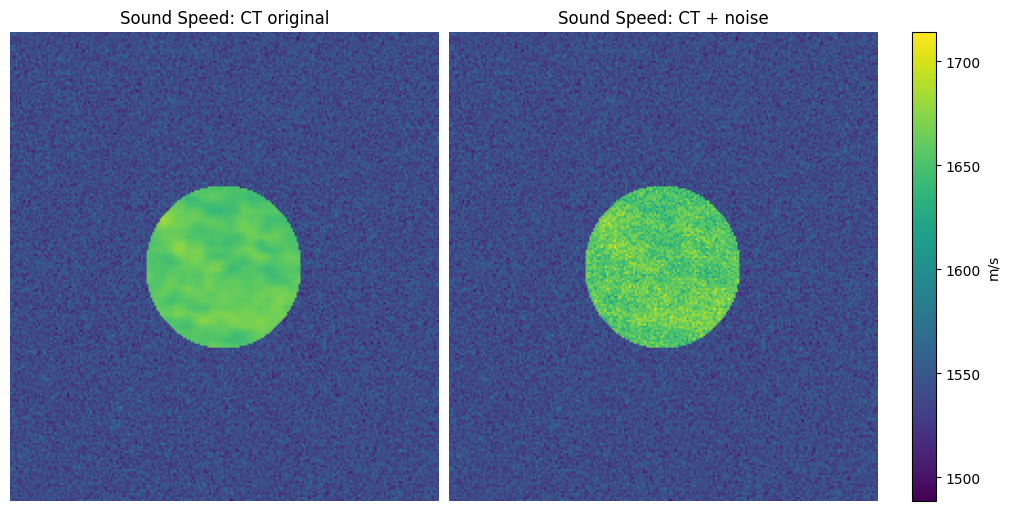

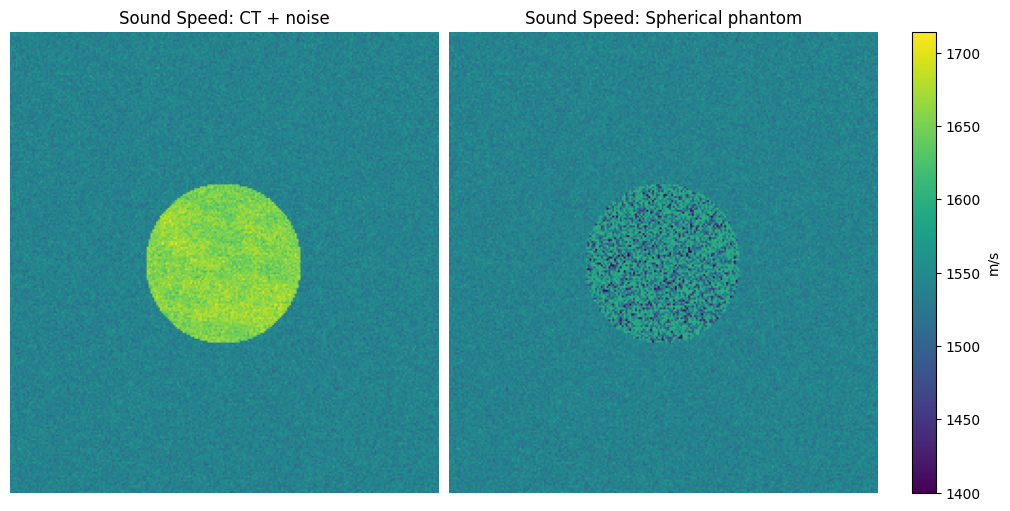

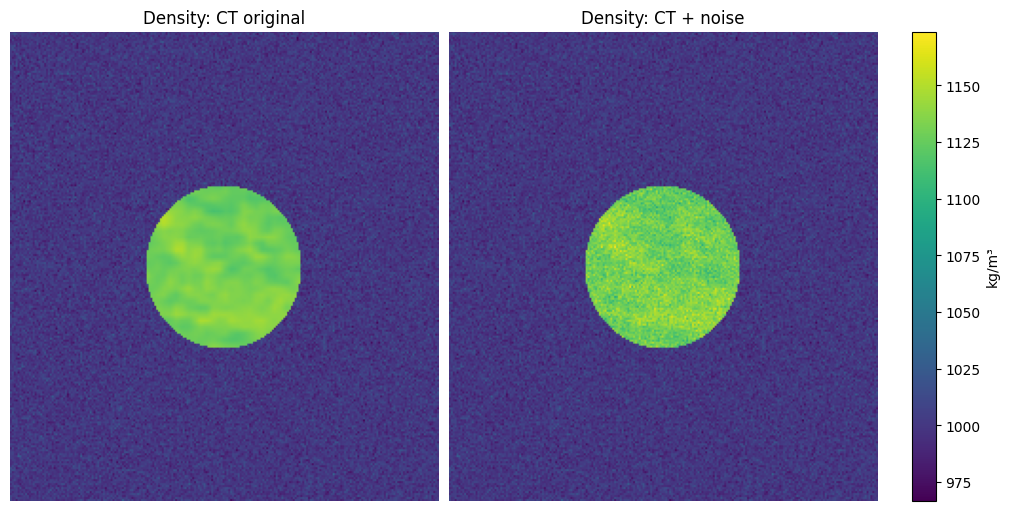

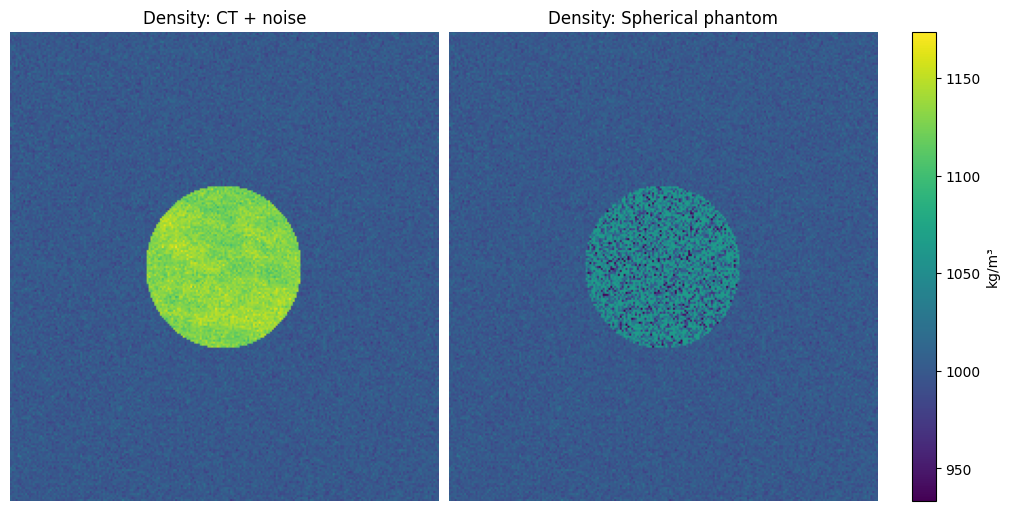

In [18]:
"""Background"""
# define a random distribution of scatterers for the background
background_map_mean = 1
background_map_std = 0.008
background_map = background_map_mean + background_map_std * np.random.randn(kgrid.Nx, kgrid.Ny, kgrid.Nz)
sound_speed_map_background = c0 * background_map
print("DEBUG: BACKGROUND")
print("Minimum SOUND SPEED in BACKGROUND: ", sound_speed_map_background.min())
print("Maximum SOUND SPEED in BACKGROUND: ", sound_speed_map_background.max())
density_map_background = rho0 * background_map
print("Minimum DENSITY in BACKGROUND: ", density_map_background.min())
print("Maximum DENSITY in BACKGROUND: ", density_map_background.max())

"""Spheric scattering phantom"""
# define a random distribution of scatterers for the medium
sound_speed_map_phantom = sound_speed_map_background.copy()
density_map_phantom = density_map_background.copy()
# define a random distribution of scatterers for the highly scattering region
scattering_map_phantom = np.random.randn(kgrid.Nx, kgrid.Ny, kgrid.Nz)
scattering_c0 = np.clip(c0 + 25 + 75 * scattering_map_phantom, 1400, 1600)
scattering_rho0 = scattering_c0 / 1.5
# define a sphere for a highly scattering region
radius = 9e-3
# x_pos = 32e-3
# y_pos = kgrid.dy * kgrid.Ny / 2
# z_pos = kgrid.dz * kgrid.Nz / 2
ball_center = np.round(Vector(grid_center))
# ball_center = np.round(Vector([x_pos, y_pos, z_pos]) / kgrid.dx)
scattering_region_phantom = make_ball(grid_size_points, ball_center, round(radius / kgrid.dx)).nonzero()
print("DEBUG: SPHERIC PHANTOM")
print("Minimum SOUND SPEED in SPHERIC PHANTOM: ", scattering_c0[scattering_region_phantom].min())
print("Maximum SOUND SPEED in SPHERIC PHANTOM: ", scattering_c0[scattering_region_phantom].max())
print("Minimum DENSITY in SPHERIC PHANTOM: ", scattering_rho0[scattering_region_phantom].min())
print("Maximum DENSITY in SPHERIC PHANTOM: ", scattering_rho0[scattering_region_phantom].max())
# define maps
sound_speed_map_phantom[scattering_region_phantom] = scattering_c0[scattering_region_phantom]
density_map_phantom[scattering_region_phantom] = scattering_rho0[scattering_region_phantom]
print("Minimum SOUND SPEED in SPHERIC PHANTOM + BACKGROUND: ", sound_speed_map_phantom.min())
print("Maximum SOUND SPEED in SPHERIC PHANTOM + BACKGROUND: ", sound_speed_map_phantom.max())
print("Minimum DENSITY in SPHERIC PHANTOM + BACKGROUND: ", density_map_phantom.min())
print("Maximum DENSITY in SPHERIC PHANTOM + BACKGROUND: ", density_map_phantom.max())

"""CT volume"""
# scattering medium from cropped CT file (liver)
FILENAME_CT = "volumeCropped.nii"
ct_img = nib.load(FILENAME_CT)
ct_vol = ct_img.get_fdata()
ct_vol_correction = ct_vol + 1024.0
ct_zooms  = np.array(ct_img.header.get_zooms()) # mm/voxel
ct_shape  = np.array(ct_vol.shape)              # voxels
phys_size_ct = ct_shape * ct_zooms              # mm
print("DEBUG: CT VOLUME RESAMPLING")
print("CT resolution in mm/voxel: ", ct_zooms)
print("CT dimensons in voxel: ", ct_shape)
print("CT dimensons in mm: ", phys_size_ct)
# k-Wave grid
dx, dy, dz = kgrid.dx*1e3, kgrid.dy*1e3, kgrid.dz*1e3
grid_zooms = np.array([dx, dy, dz])
phys_size_grid = grid_size_points * grid_zooms
print("Grid resolution in mm/voxel: ", grid_zooms)
print("Grid dimensons in voxel: ", grid_size_points)
print("Grid dimensons in mm: ", phys_size_grid)
# resampling: CT resolution -> grid resolution
zoom_factor = ct_zooms / grid_zooms
ct_resamp = zoom(ct_vol_correction, zoom_factor, order=1).astype(np.float32)
ct_resamp_shape = np.array(ct_resamp.shape, dtype = int)
# print("Zoom factor: ", zoom_factor)
print("CT dimensons in voxel AFTER RESAMPLING: ", ct_resamp_shape)
if np.any(ct_resamp_shape > grid_size_points):
    raise ValueError(f"CT ({ct_resamp_shape}) does not fit in grid ({grid_size_points})")
# CT maps
sound_speed_cube = hounsfield2soundspeed(ct_resamp).astype(np.float32)
# print("Sound speed cube dimensions in voxels: ", sound_speed_cube.shape)
print("DEBUG: CT VOLUME")
print("Minimum SOUND SPEED in CT: ", sound_speed_cube.min())
print("Maximum SOUND SPEED in CT: ", sound_speed_cube.max())
density_cube = hounsfield2density(ct_resamp, plot_fitting=False).astype(np.float32)
print("Minimum DENSITY in CT: ", density_cube.min())
print("Maximum DENSITY in CT: ", density_cube.max())
# build spheric region
ct_ball_center = np.round(Vector(ct_resamp_shape/2.0))
ct_ball = make_ball(Vector(ct_resamp_shape), ct_ball_center, round(radius / kgrid.dx)).nonzero()
# build maps
sound_speed_map = sound_speed_map_background.copy()
density_map = density_map_background.copy()
sound_speed_map[scattering_region_phantom] = sound_speed_cube[ct_ball]
density_map[scattering_region_phantom] = density_cube[ct_ball]

"""Add noise to CT"""
# build noise for CT
ct_map_mean = 1
ct_map_std = 0.008
ct_noise = ct_map_mean + ct_map_std * np.random.randn(*sound_speed_cube[ct_ball].shape)
# add noise on CT maps
sound_speed_sphere_noise = sound_speed_cube[ct_ball] * ct_noise
density_sphere_noise = density_cube[ct_ball] * ct_noise
# build map
sound_speed_map_noise = sound_speed_map_background.copy()
density_map_noise = density_map_background.copy()
sound_speed_map_noise[scattering_region_phantom] = sound_speed_sphere_noise
density_map_noise[scattering_region_phantom] = density_sphere_noise
print("DEBUG: CT + NOISE")
print("Minimum SOUND SPEED in CT NOISE: ", sound_speed_sphere_noise.min())
print("Maximum SOUND SPEED in CT NOISE: ", sound_speed_sphere_noise.max())
print("Minimum DENSITY in CT NOISE: ", density_sphere_noise.min())
print("Maximum DENSITY in CT NOISE: ", density_sphere_noise.max())

"""Conversion to HU"""
# ——————————————————————————————————————————————————————————
# Assumptions: earlier in your script you have these variables defined:
#   ct_resamp            # CT volume already in HU, resampled onto the k-Wave grid
#   density_map          # full CT-based density map (background + CT) in kg/m³
#   density_map_ball     # full spherical-phantom density map in kg/m³
#   sx, ex, sy, ey, sz, ez  # integer indices delimiting the CT “cube” region
# ——————————————————————————————————————————————————————————
# flatten HU and density values within the CT cube
hu_vals = ct_resamp[ct_ball].ravel()
print(hu_vals.shape)
d_vals  = density_cube[ct_ball].ravel()
print(d_vals.shape)
# filter out any non-finite entries (NaN, Inf)
mask = np.isfinite(hu_vals) & np.isfinite(d_vals)
hu_vals = hu_vals[mask]
d_vals  = d_vals[mask]
# linear regression: d = m * HU + b
m, b = np.polyfit(hu_vals, d_vals, 1)
print(f"Fitted model: d = {m:.4f}·HU + {b:.2f}   (kg/m³)")
# define inverse function: HU = (d - b) / m
def density_to_hu(d_map):
    """
    Convert a density map back to Hounsfield Units
    using the linear model derived from the CT data.
    """
    return (d_map - b) / m
# apply to spherical phantom map
hu_sphere = density_to_hu(density_map_phantom)

"""CT PLOTS"""
"""Plot original vs resampled slices"""
# extract middle slices
mid_z_vol = ct_vol.shape[2] // 2
mid_z_res = ct_resamp.shape[2] // 2
slice_vol = ct_vol[:, :, mid_z_vol]
slice_res = ct_resamp[:, :, mid_z_res]
# shared normalization across both slices
vmin = min(slice_vol.min(), slice_res.min())
vmax = max(slice_vol.max(), slice_res.max())
norm = Normalize(vmin=vmin, vmax=vmax)
# plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
# original volume
im1 = axs[0].imshow(slice_vol.T, cmap='gray', norm=norm, origin='lower')
axs[0].set_title(f'CT Original Z={mid_z_vol}')
axs[0].axis('off')
# resampled volume
im2 = axs[1].imshow(slice_res.T, cmap='gray', norm=norm, origin='lower')
axs[1].set_title(f'CT Resampled Z={mid_z_res}')
axs[1].axis('off')
# single colorbar for both
cbar = fig.colorbar(im2, ax=axs, location='right', fraction=0.046, pad=0.04)
cbar.set_label('CT Intensity (HU)')
plt.show()
"""Plot original CT HU vs. phantom HU"""
ct_full = hu_sphere.copy()
ct_full[scattering_region_phantom] = ct_resamp[ct_ball]
# extract the central Z-slice for comparison
mid_z = hu_sphere.shape[2] // 2
ct_slice_hu = ct_full[:, :, mid_z]
sphere_slice_hu = hu_sphere[:, :, mid_z]
# set up a consistent grayscale normalization
vmin = min(ct_slice_hu.min(), sphere_slice_hu.min())
vmax = max(ct_slice_hu.max(), sphere_slice_hu.max())
norm = Normalize(vmin=vmin, vmax=vmax)
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
axes[0].imshow(ct_slice_hu.T, cmap='gray', origin='lower', norm=norm)
axes[0].set_title('Original CT (HU)')
axes[0].axis('off')
im = axes[1].imshow(sphere_slice_hu.T, cmap='gray', origin='lower', norm=norm)
axes[1].set_title('Spherical Phantom → HU via Density')
axes[1].axis('off')
# add a single colorbar for both panels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Hounsfield Units (HU)')
plt.show()


mid_z = kgrid.Nz // 2
"""SOUND SPEED PLOTS"""
"""Extract middle slice"""
slice_orig  = sound_speed_map[:, :, mid_z]
slice_noise = sound_speed_map_noise[:, :, mid_z]
slice_ball  = sound_speed_map_phantom[:, :, mid_z]
"""Plot: CT original vs CT + noise"""
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
vmin = min(slice_orig.min(), slice_noise.min())
vmax = max(slice_orig.max(), slice_noise.max())
norm = Normalize(vmin=vmin, vmax=vmax)
axs[0].imshow(slice_orig.T,  origin='lower', aspect='auto', norm=norm)
axs[0].set_title('Sound Speed: CT original')
axs[0].axis('off')
im = axs[1].imshow(slice_noise.T, origin='lower', aspect='auto', norm=norm)
axs[1].set_title('Sound Speed: CT + noise')
axs[1].axis('off')
cbar = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('m/s')
plt.show()
"""Plot: CT + noise vs Spherical phantom"""
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
vmin = min(slice_noise.min(), slice_ball.min())
vmax = max(slice_noise.max(), slice_ball.max())
norm = Normalize(vmin=vmin, vmax=vmax)
axs[0].imshow(slice_noise.T, origin='lower', aspect='auto', norm=norm)
axs[0].set_title('Sound Speed: CT + noise')
axs[0].axis('off')
im = axs[1].imshow(slice_ball.T, origin='lower', aspect='auto', norm=norm)
axs[1].set_title('Sound Speed: Spherical phantom')
axs[1].axis('off')
cbar = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('m/s')
plt.show()

"""DENSITY PLOTS"""
"""Extract middle slice"""
slice_rho_orig  = density_map       [:, :, mid_z]
slice_rho_noise = density_map_noise [:, :, mid_z]
slice_rho_ball  = density_map_phantom  [:, :, mid_z]
"""Plot: CT original vs CT + noise (densità)"""
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
vmin = min(slice_rho_orig.min(), slice_rho_noise.min())
vmax = max(slice_rho_orig.max(), slice_rho_noise.max())
norm = Normalize(vmin=vmin, vmax=vmax)
axs[0].imshow(slice_rho_orig.T,  origin='lower', aspect='auto', norm=norm)
axs[0].set_title('Density: CT original')
axs[0].axis('off')
im = axs[1].imshow(slice_rho_noise.T, origin='lower', aspect='auto', norm=norm)
axs[1].set_title('Density: CT + noise')
axs[1].axis('off')
cbar = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('kg/m³')
plt.show()
"""Plot: CT + noise vs Spherical phantom (densità)"""
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
vmin = min(slice_rho_noise.min(), slice_rho_ball.min())
vmax = max(slice_rho_noise.max(), slice_rho_ball.max())
norm = Normalize(vmin=vmin, vmax=vmax)
axs[0].imshow(slice_rho_noise.T, origin='lower', aspect='auto', norm=norm)
axs[0].set_title('Density: CT + noise')
axs[0].axis('off')
im = axs[1].imshow(slice_rho_ball.T, origin='lower', aspect='auto', norm=norm)
axs[1].set_title('Density: Spherical phantom')
axs[1].axis('off')
cbar = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('kg/m³')
plt.show()

In [19]:
medium.sound_speed = sound_speed_map_noise
medium.density = density_map_noise

# Range of steering angles to test
steering_angles = np.arange(-32, 33, 2)

# Preallocate the storage
number_scan_lines = len(steering_angles)
scan_lines = np.zeros((number_scan_lines, kgrid.Nt))

if RUN_SIMULATION:
    for angle_index in range(number_scan_lines):
        print(f'Computing scan line {angle_index} of {number_scan_lines}')

        # set the input settings
        input_filename = f'example_input_{angle_index}.h5'
        # set the input settings
        simulation_options = SimulationOptions(
            pml_inside=False,
            pml_size=pml_size_points,
            data_cast=DATA_CAST,
            data_recast=True,
            save_to_disk=True,
            input_filename=input_filename,
            save_to_disk_exit=False
        )

        # Update the current steering angle
        not_transducer.steering_angle = steering_angles[angle_index]

        sensor_data = kspaceFirstOrder3D(
            medium=deepcopy(medium),  # Medium is altered in-place in this function
            kgrid=kgrid,
            source=not_transducer,
            sensor=not_transducer,
            simulation_options=simulation_options,
            execution_options=SimulationExecutionOptions(is_gpu_simulation=True)
        )

        scan_lines[angle_index, :] = not_transducer.scan_line(not_transducer.combine_sensor_data(sensor_data['p'].T))

    scipy.io.savemat('example_us_phased_array_scan_lines.mat', {'scan_lines': scan_lines})
else:
    scan_lines = scipy.io.loadmat('example_us_phased_array_scan_lines')['scan_lines']


Computing scan line 0 of 33
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────

## PROCESS THE RESULTS
### Remove Input Signal

In [20]:
# Trim the delay offset from the scan line data
t0_offset = int(round(len(input_signal.squeeze())/ 2) + (not_transducer.appended_zeros - not_transducer.beamforming_delays_offset))

scan_lines = scan_lines[:, t0_offset:]

Nt = np.shape(scan_lines)[1]


In [21]:

tukey_win, _ = get_win(Nt * 2, 'Tukey', False, 0.05)
scan_line_win = np.concatenate((np.zeros([1, t0_offset * 2]), tukey_win.T[:, :int(len(tukey_win)/2) - t0_offset * 2]), axis=1)

scan_lines = scan_lines * scan_line_win
# store intermediate results

### Time Gain Compensation

In [22]:
# Create radius variable
r = c0 * np.arange(1, Nt + 1) * kgrid.dt / 2

# Define absorption value and convert to correct units
tgc_alpha_db_cm = medium.alpha_coeff * (tone_burst_freq * 1e-6)**medium.alpha_power
tgc_alpha_np_m = db2neper(tgc_alpha_db_cm) * 100

# Create time gain compensation function
tgc = np.exp(tgc_alpha_np_m * 2 * r)

# Apply the time gain compensation to each of the scan lines
scan_lines *= tgc

### Frequency Filtering

In [23]:
scan_lines_fund = gaussian_filter(scan_lines, 1/kgrid.dt, tone_burst_freq, 100)
scan_lines_harm = gaussian_filter(scan_lines, 1/kgrid.dt, 2 * tone_burst_freq, 30)

### Envelope Detection

In [24]:
scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

### Log Compression

In [25]:
compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

### Visualization

In [26]:
image_size = [kgrid.Nx * kgrid.dx, kgrid.Ny * kgrid.dy]
image_res = [256, 256]

b_mode_fund = scan_conversion(scan_lines_fund, steering_angles, image_size, c0, kgrid.dt, image_res)
b_mode_harm = scan_conversion(scan_lines_harm, steering_angles, image_size, c0, kgrid.dt, image_res)

In [27]:
# Create the axis variables
x_axis = [0, image_size[0] * 1e3] # [mm]
y_axis = [0, image_size[1] * 1e3]  # [mm]

Text(0.5, 1.0, 'B-Mode Image')

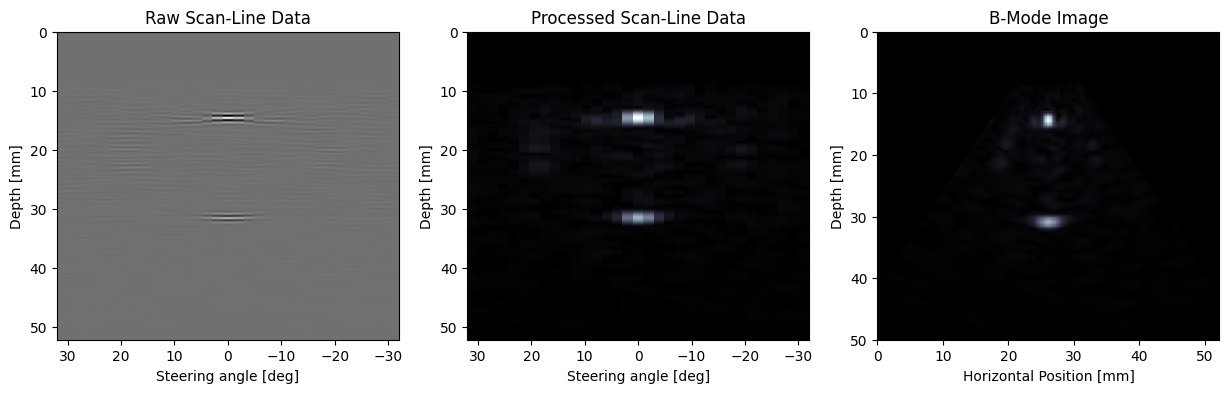

In [28]:
plt.ion()
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(scan_lines.T, aspect='auto',
             extent=[steering_angles[-1], steering_angles[0],y_axis[1], y_axis[0] ], interpolation='none', cmap='gray')
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Raw Scan-Line Data')


plt.subplot(132)
plt.imshow(scan_lines_fund.T, aspect='auto',
            extent=[steering_angles[-1], steering_angles[0],y_axis[1], y_axis[0] ],  interpolation='none', cmap='bone')
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Processed Scan-Line Data')

plt.subplot(133)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

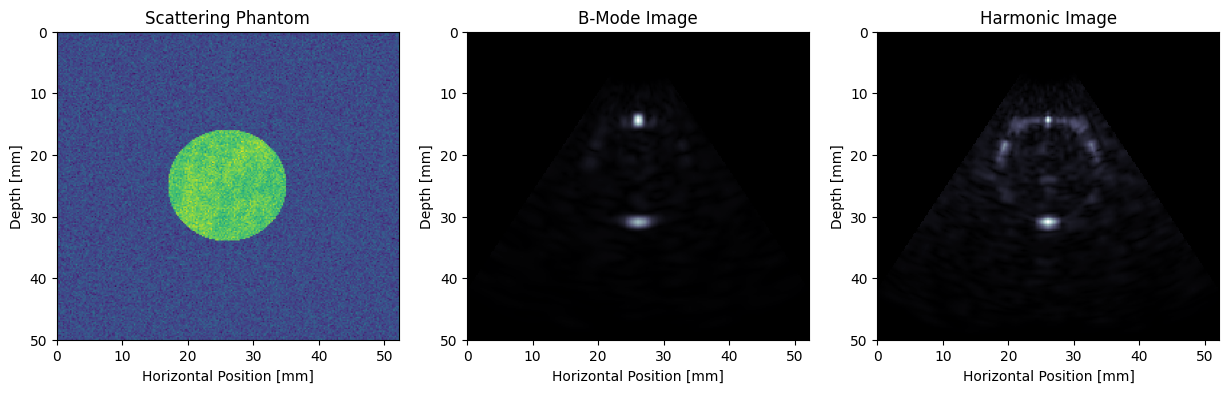

In [29]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(medium.sound_speed[..., kgrid.Nz//2], aspect='auto',
            extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Scattering Phantom')

plt.subplot(132)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

plt.subplot(133)
plt.imshow(b_mode_harm, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Harmonic Image')

plt.show()
